**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

*All the text in italics is instructions for filling the template - remove when writing the project report!*

# *Title* 

*Title should be concise and informative, describes the approach to solve the problem. Some good titles from previous years:*

*- Comparing extreme learning machines and naive bayes’ classifier in spam detection*

*- Using linear discriminant analysis in spam detection*

*Some not-so-good titles:*

*- Bayesian spam filtering with extras*

*- Two-component classifier for spam detection*

*- CS-E3210 Term Project, final report*




## Abstract

*Precise summary of the whole report, previews the contents and results. Must be a single paragraph between 100 and 200 words.*



## 1. Introduction

*Background, problem statement, motivation, many references, description of
contents. Introduces the reader to the topic and the broad context within which your
research/project fits*

*- What do you hope to learn from the project?*
*- What question is being addressed?*
*- Why is this task important? (motivation)*

*Keep it short (half to 1 page).*



## 2. Data analysis

*Briefly describe data (class distribution, dimensionality) and how will it affect
classification. Visualize the data. Don’t focus too much on the meaning of the features,
unless you want to.*

*- Include histograms showing class distribution.*



In [7]:
# Import dependencies
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn import metrics as met
from sklearn.model_selection import train_test_split as TTSplit
from sklearn.metrics import classification_report as ClassRep
from sklearn.metrics import confusion_matrix as ConfMat
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn import preprocessing

# Reading the train and test files
XTrainData = pd.read_csv("train_data.csv", header = None).values
YTrainData = pd.read_csv("train_labels.csv", header = None).values
XTestData = pd.read_csv("test_data.csv", header = None).values

# Remove outliers (TODO)

# Normalize the data with minmax
min_max_scaler = preprocessing.MinMaxScaler()
XTrainData = min_max_scaler.fit_transform(XTrainData)

#print 'XTrainData Shape:', XTrainData.shape

# Splitting the Test Data into Training and Testing Sets (both Features and Labels) 
XTrainSet, XTestSet, YTrainSet, YTestSet = TTSplit(XTrainData, YTrainData, test_size = 0.7)
Test_LabelSet_Size = len(YTestSet)
Train_LabelSet_Size = len(YTrainSet)

# Reshaping and preparing the training and testing sets. (R put with variable name (R = Refined)) (Just re-shaped for now. To be refined later)
YTestR = np.reshape(YTestSet, (Test_LabelSet_Size, 1))
YTrainR = np.reshape(YTrainSet, (Train_LabelSet_Size, 1))

#print 'YTestR Shape:', YTestR.shape

''' 
Multinomial Logistic Regression on the data
    Iterations = 7500
    Inverse Regularization Constant = 1e-3 (lambda = 1000)
    Solver = SAG (Stochastic Average Gradient) descent 
'''
C = 0.1
testAcc = []
validAcc = []
C_array = []
while C < 10:
    print('C:',C)
    logreg = LogReg(C = C, max_iter = 7500, solver ='sag', multi_class = 'multinomial')

    # Fitting the refined training sets 
    logreg.fit(XTrainSet, YTrainR)

    # Calculation of training accuracy
    predictTest = logreg.predict(XTestSet)
    predictTrain = logreg.predict(XTrainSet)

    # Display the calculated accuracies
    print('Training Accuracy: ', met.accuracy_score(predictTrain, YTrainR))
    print('Testing Accuracy: ', met.accuracy_score(predictTest, YTestR))
    testAcc.append(met.accuracy_score(predictTrain, YTrainR))
    validAcc.append(met.accuracy_score(predictTest, YTestR))
    C_array.append(C)
    # Display final score from Logistic Regression
    score = logreg.score(XTestSet, YTestSet)
    print('Final Score: ', score)
    C = C*1.2


C: 0.1


c:\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy:  0.617737003058104
Testing Accuracy:  0.5937806873977087
Final Score:  0.5937806873977087
C: 0.12


c:\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy:  0.6223241590214067
Testing Accuracy:  0.6009819967266776
Final Score:  0.6009819967266776
C: 0.144


c:\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy:  0.6284403669724771
Testing Accuracy:  0.6078559738134206
Final Score:  0.6078559738134206
C: 0.17279999999999998


c:\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy:  0.6368501529051988
Testing Accuracy:  0.6121112929623568
Final Score:  0.6121112929623568
C: 0.20735999999999996


c:\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy:  0.6444954128440367
Testing Accuracy:  0.613747954173486
Final Score:  0.613747954173486
C: 0.24883199999999994


c:\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy:  0.6498470948012233
Testing Accuracy:  0.6180032733224222
Final Score:  0.6180032733224222
C: 0.29859839999999993


c:\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy:  0.6613149847094801
Testing Accuracy:  0.6202945990180033
Final Score:  0.6202945990180033
C: 0.3583180799999999


c:\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy:  0.6712538226299695
Testing Accuracy:  0.6212765957446809
Final Score:  0.6212765957446809
C: 0.4299816959999999


c:\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy:  0.6773700305810397
Testing Accuracy:  0.6265139116202946
Final Score:  0.6265139116202946
C: 0.5159780351999999


c:\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy:  0.6873088685015291
Testing Accuracy:  0.6288052373158756
Final Score:  0.6288052373158756
C: 0.6191736422399998


c:\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy:  0.6964831804281345
Testing Accuracy:  0.6310965630114567
Final Score:  0.6310965630114567
C: 0.7430083706879997


c:\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy:  0.7033639143730887
Testing Accuracy:  0.6330605564648117
Final Score:  0.6330605564648117
C: 0.8916100448255997


c:\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy:  0.7079510703363915
Testing Accuracy:  0.6369885433715221
Final Score:  0.6369885433715221
C: 1.0699320537907195


c:\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy:  0.7140672782874617
Testing Accuracy:  0.6369885433715221
Final Score:  0.6369885433715221
C: 1.2839184645488635


c:\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy:  0.7232415902140673
Testing Accuracy:  0.6386252045826514
Final Score:  0.6386252045826514
C: 1.5407021574586361


c:\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy:  0.7301223241590215
Testing Accuracy:  0.639607201309329
Final Score:  0.639607201309329
C: 1.8488425889503632


c:\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy:  0.7392966360856269
Testing Accuracy:  0.6340425531914894
Final Score:  0.6340425531914894
C: 2.2186111067404357


c:\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy:  0.7469418960244648
Testing Accuracy:  0.6333878887070377
Final Score:  0.6333878887070377
C: 2.662333328088523


c:\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy:  0.7584097859327217
Testing Accuracy:  0.6327332242225859
Final Score:  0.6327332242225859
C: 3.1947999937062272


c:\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy:  0.7675840978593272
Testing Accuracy:  0.6343698854337152
Final Score:  0.6343698854337152
C: 3.8337599924474723


c:\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy:  0.7759938837920489
Testing Accuracy:  0.6310965630114567
Final Score:  0.6310965630114567
C: 4.600511990936966


c:\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy:  0.7882262996941896
Testing Accuracy:  0.6304418985270049
Final Score:  0.6304418985270049
C: 5.5206143891243595


c:\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy:  0.7951070336391437
Testing Accuracy:  0.6297872340425532
Final Score:  0.6297872340425532
C: 6.624737266949231


c:\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy:  0.8027522935779816
Testing Accuracy:  0.628150572831424
Final Score:  0.628150572831424
C: 7.949684720339077


c:\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy:  0.8157492354740061
Testing Accuracy:  0.6258592471358428
Final Score:  0.6258592471358428
C: 9.539621664406893


c:\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy:  0.8226299694189603
Testing Accuracy:  0.6235679214402619
Final Score:  0.6235679214402619


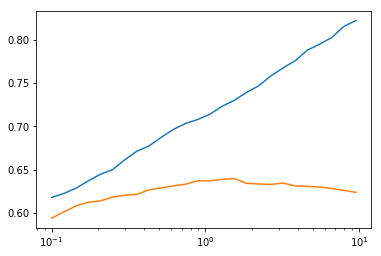

In [9]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(C_array,testAcc)
plt.plot(C_array,validAcc)
plt.xscale('log')
plt.show()

In [ ]:
# Load the data and cleanup

In [ ]:
#Analysis of the input data
# ...

## 3. Methods and experiments

*- Explain your whole approach (you can include a block diagram showing the steps in your process).* 

*- What methods/algorithms, why were the methods chosen. *

*- What evaluation methodology (cross CV, etc.).*



In [ ]:
# Trials with ML algorithms

## 4. Results

*Summarize the results of the experiments without discussing their implications.*

*- Include both performance measures (accuracy and LogLoss).*

*- How does it perform on kaggle compared to the train data.*

*- Include a confusion matrix.*



In [ ]:
#Confusion matrix ...

## 5. Discussion/Conclusions

*Interpret and explain your results *

*- Discuss the relevance of the performance measures (accuracy and LogLoss) for
imbalanced multiclass datasets. *

*- How the results relate to the literature. *

*- Suggestions for future research/improvement. *

*- Did the study answer your questions? *



## 6. References

*List of all the references cited in the document*

## Appendix
*Any additional material needed to complete the report can be included here. For example, if you want to keep  additional source code, additional images or plots, mathematical derivations, etc. The content should be relevant to the report and should help explain or visualize something mentioned earlier. **You can remove the whole Appendix section if there is no need for it.** *